In [ ]:
import os
import cv2
import numpy as np
import mediapipe as mp

mp_pose = mp.solutions.pose

# ====== CONFIGURATION ======
CLIP_DIR = 'clips'
OUTPUT_DIR = 'smoothed_landmarks'
SMOOTHING_WINDOW = 5

# ====== STEP 1: Extract pose landmarks from each clip ======
def extract_landmarks(data_paths):
    """
    Extracts pose landmarks from each clip using MediaPipe Pose and returns
    a dictionary of clip_id → landmarks array (frames x 33 x 4).
    """
    all_landmarks = {}
    for idx, clip in enumerate(data_paths):
        clip_path = os.path.join(CLIP_DIR, clip)
        cap = cv2.VideoCapture(clip_path)
        frame_landmarks = []

        with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
            while True:
                ret, frame = cap.read()
                if not ret:
                    break

                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame.flags.writeable = False
                results = pose.process(frame)
                frame.flags.writeable = True

                if results.pose_landmarks:
                    landmarks = [[lm.x, lm.y, lm.z, lm.visibility] for lm in results.pose_landmarks.landmark]
                else:
                    landmarks = [[0, 0, 0, 0]] * 33

                frame_landmarks.append(landmarks)

        cap.release()
        clip_array = np.array(frame_landmarks, dtype=np.float32)
        all_landmarks[idx + 1] = clip_array  # clip_001.npy → 1, etc.

    return all_landmarks

# ====== STEP 2: Apply temporal smoothing to reduce jitter ======
def moving_average_smoothing(all_clips, window=5):
    """
    Applies moving average smoothing over frames for each clip.
    """
    smoothed_clips = {}
    pad = window // 2

    for clip_id, clip in all_clips.items():
        padded = np.pad(clip, ((pad, pad), (0, 0), (0, 0)), mode='edge')
        smoothed = np.empty_like(clip)
        for i in range(clip.shape[0]):
            smoothed[i] = np.mean(padded[i:i + window], axis=0)
        smoothed_clips[clip_id] = smoothed

    return smoothed_clips

# ====== STEP 3: Save extracted landmarks to .npy files ======
def save_landmarks(smoothed_clips, output_dir=OUTPUT_DIR):
    """
    Saves each clip's smoothed landmarks as a .npy file in the specified directory.
    """
    os.makedirs(output_dir, exist_ok=True)
    for clip_id, clip_data in smoothed_clips.items():
        filename = f"clip_{clip_id}.npy"
        path = os.path.join(output_dir, filename)
        np.save(path, clip_data)
        print(f"Saved: {path}")

# ====== MAIN PIPELINE ======
if __name__ == "__main__":
    clip_files = sorted(os.listdir(CLIP_DIR))
    all_clips = extract_landmarks(clip_files)
    smoothed_clips = moving_average_smoothing(all_clips, window=SMOOTHING_WINDOW)
    save_landmarks(smoothed_clips)


In [5]:
def load_landmarks_from_file(input_dir='smoothed_landmarks'):
    loaded_clips = {}
    for filename in os.listdir(input_dir):
        if filename.endswith('.npy'):
            clip_id = int(filename.split('_')[1].split('.')[0])
            clip_data = np.load(os.path.join(input_dir, filename))
            loaded_clips[clip_id] = clip_data
    return loaded_clips
smoothed_clips = load_landmarks_from_file()

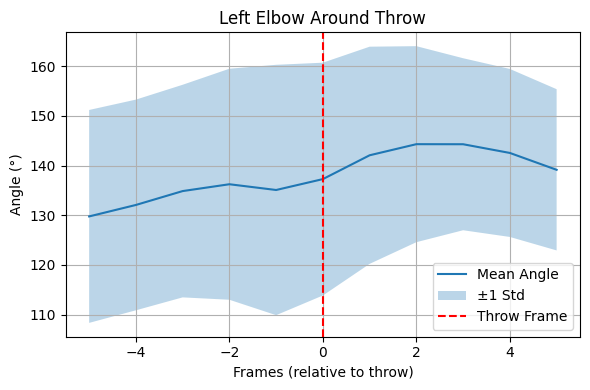

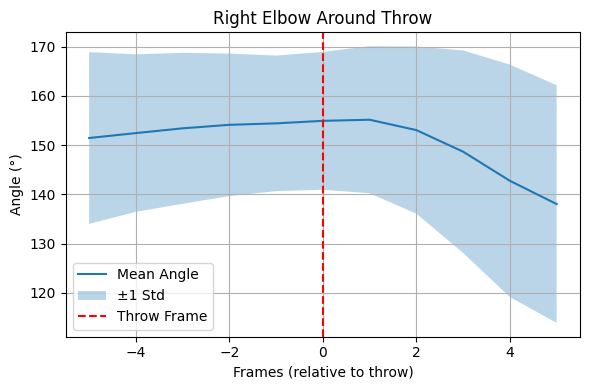

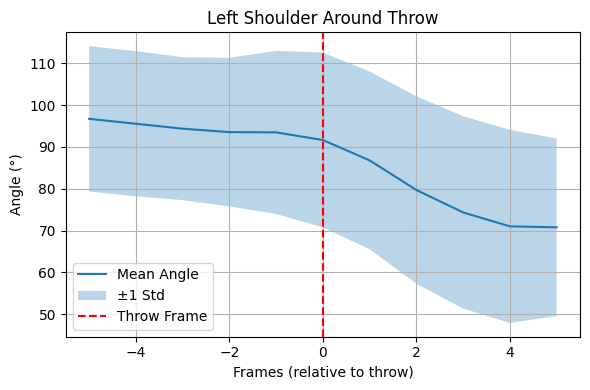

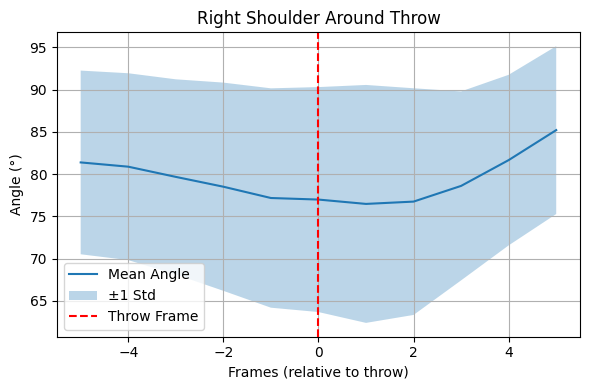

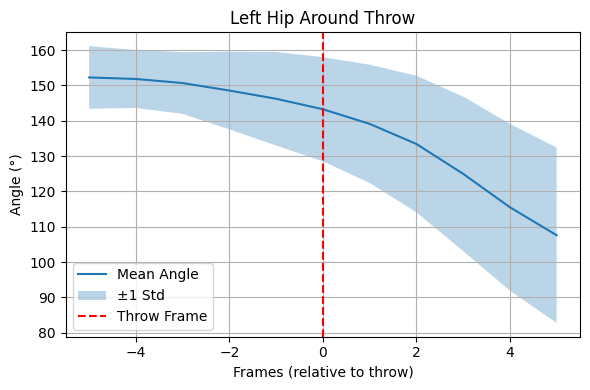

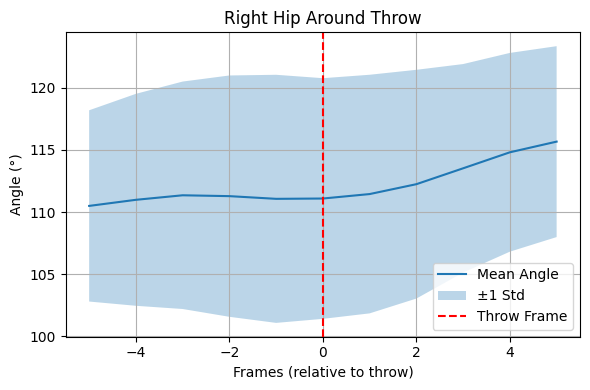

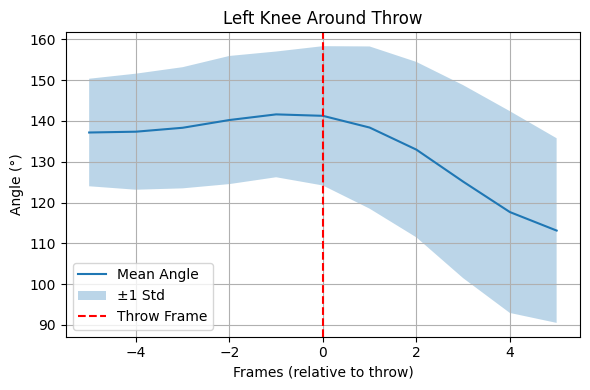

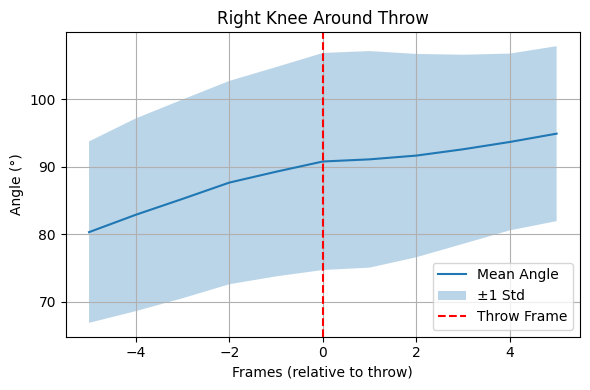

In [393]:
import os
import numpy as np
import matplotlib.pyplot as plt

# ===== Joint Angle Utilities =====
def angle_between(a, b, c):
    """Computes the angle at point `b` formed by a-b-c across frames."""
    ba = a - b
    bc = c - b
    dot = np.sum(ba * bc, axis=1)
    mag = np.linalg.norm(ba, axis=1) * np.linalg.norm(bc, axis=1)
    cos_theta = np.clip(dot / (mag + 1e-8), -1.0, 1.0)
    return np.arccos(cos_theta)  # in radians

def compute_joint_angles(smoothed_clips):
    """Computes angles for key joints across all clips."""
    joint_angles = {}
    for clip_id, L in smoothed_clips.items():
        angles = {}
        angles['left_elbow']    = np.degrees(angle_between(L[:,11], L[:,13], L[:,15]))
        angles['right_elbow']   = np.degrees(angle_between(L[:,12], L[:,14], L[:,16]))
        angles['left_shoulder'] = np.degrees(angle_between(L[:,23], L[:,11], L[:,13]))
        angles['right_shoulder']= np.degrees(angle_between(L[:,24], L[:,12], L[:,14]))
        angles['left_hip']      = np.degrees(angle_between(L[:,11], L[:,23], L[:,25]))
        angles['right_hip']     = np.degrees(angle_between(L[:,12], L[:,24], L[:,26]))
        angles['left_knee']     = np.degrees(angle_between(L[:,23], L[:,25], L[:,27]))
        angles['right_knee']    = np.degrees(angle_between(L[:,24], L[:,26], L[:,28]))
        joint_angles[clip_id] = angles
    return joint_angles

# ===== Analysis Around Throw Frame =====
def extract_angle_window(joint_angles, throw_frames_dict, window=5):
    """
    Extracts joint angles ± `window` frames around the throw frame.
    Returns: dict of joint name → (N_clips, 2*window+1) angle matrix.
    """
    angle_windows = {}
    for joint in list(next(iter(joint_angles.values())).keys()):
        joint_matrix = []
        for clip_id, angles in joint_angles.items():
            if clip_id not in throw_frames_dict:
                continue
            t = throw_frames_dict[clip_id]
            angle_seq = angles[joint]
            if t - window < 0 or t + window >= len(angle_seq):
                continue
            window_seq = angle_seq[t - window:t + window + 1]
            joint_matrix.append(window_seq)
        angle_windows[joint] = np.array(joint_matrix)
    return angle_windows

def plot_joint_stats(angle_windows):
    for joint, matrix in angle_windows.items():
        if matrix.size == 0:
            continue
        mean = np.mean(matrix, axis=0)
        std  = np.std(matrix, axis=0)
        frames = np.linspace(-((matrix.shape[1] - 1)//2), ((matrix.shape[1] - 1)//2), matrix.shape[1], dtype=int)

        plt.figure(figsize=(6, 4))
        plt.plot(frames, mean, label="Mean Angle")
        plt.fill_between(frames, mean - std, mean + std, alpha=0.3, label="±1 Std")
        plt.axvline(x=0, color='r', linestyle='--', label='Throw Frame')
        plt.title(f"{joint.replace('_', ' ').title()} Around Throw")
        plt.xlabel("Frames (relative to throw)")
        plt.ylabel("Angle (°)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()  


# ===== MAIN EXECUTION =====
if __name__ == "__main__":
    # Load smoothed landmarks (e.g. from disk)
    smoothed_clips = {}
    for fname in sorted(os.listdir("smoothed_landmarks")):
        if not fname.endswith(".npy"): continue
        clip_id = int(fname.replace("clip_", "").replace(".npy", ""))
        smoothed_clips[clip_id] = np.load(os.path.join("smoothed_landmarks", fname))

    # Manually labeled throw frame indices
    
    # Compute and analyze
    joint_angles = compute_joint_angles(smoothed_clips)
    angle_windows = extract_angle_window(joint_angles, THROW_FRAMES, window=5)
    plot_joint_stats(angle_windows)


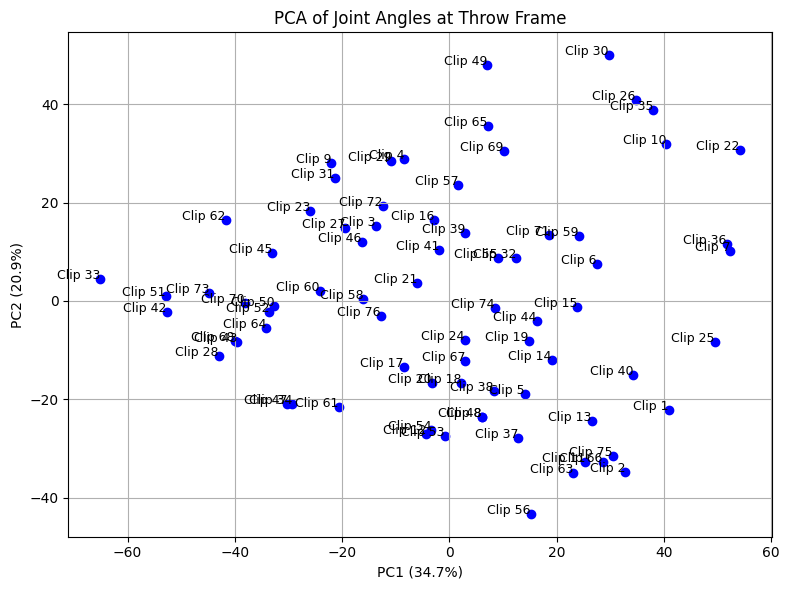

In [394]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def run_pca_on_throw_angles(joint_angles, THROW_FRAMES):
    joint_names = list(next(iter(joint_angles.values())).keys())
    clip_ids = sorted(THROW_FRAMES.keys())

    # Build matrix of shape (n_athletes, n_joints)
    angle_matrix = []
    for clip_id in clip_ids:
        frame = THROW_FRAMES[clip_id]
        angles = joint_angles[clip_id]
        vector = [angles[joint][frame] for joint in joint_names]
        angle_matrix.append(vector)

    angle_matrix = np.array(angle_matrix)

    # Apply PCA
    pca = PCA(n_components=2)
    components = pca.fit_transform(angle_matrix)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(components[:, 0], components[:, 1], color='blue')

    for i, clip_id in enumerate(clip_ids):
        plt.text(components[i, 0], components[i, 1], f"Clip {clip_id}", fontsize=9, ha='right')

    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
    plt.title("PCA of Joint Angles at Throw Frame")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return components, pca

pca_components, pca_model = run_pca_on_throw_angles(joint_angles, THROW_FRAMES)